In [ ]:
"""
  Se importan las librerías necesarias para el manejo de datos 
  e imprimirlos en pantalla y archivos para la red neuronal de YAMNet. 
  También se importa de GoogleDrive el pipline que contiene 
  el clasificado entrenado con el conjunto ESC-50.
"""
from google.colab import drive
drive.mount('/content/drive')
!git clone https://github.com/tensorflow/models.git
!cd models/research/audioset/yamnet
!curl -O https://storage.googleapis.com/audioset/yamnet.h5
!python yamnet_test.py
!cp -r models/research/audioset/yamnet/* .
!pip install soundfile
from features import *
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import params as yamnet_params
import yamnet as yamnet_model
import tensorflow as tf
from IPython.display import Audio
import pandas as pd
from imblearn.pipeline import make_pipeline
from joblib import dump, load
pipeline_entrenado = load('/content/drive/MyDrive/Voting.joblib')

In [5]:
# Se importa el archivo .wav de audio que se quiere procesar
from google.colab import files
files.upload()

Output hidden; open in https://colab.research.google.com to view.

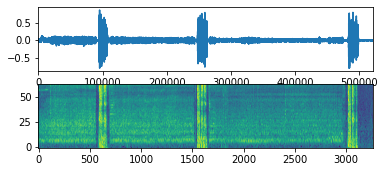

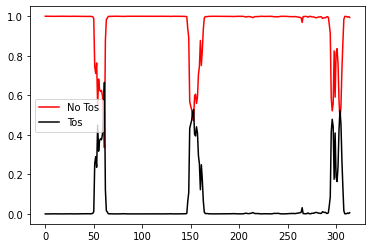

In [10]:
"""
  La función "caracteristicas_yamnet" obtiene las características
  del audio que se importada, los datas para imprimir el espectrograma 
  "spectrogram" y el "waveform" para imprimir la forma de la onda.
"""
def caracteristicas_yamnet(nombre):
  wav_file_name = nombre
  wav_data, sr = sf.read(wav_file_name, dtype=np.int16)
  waveform = wav_data / 32768.0
  params = yamnet_params.Params(sample_rate=sr, patch_hop_seconds=0.1)
  class_names = yamnet_model.class_names('yamnet_class_map.csv')
  yamnet = yamnet_model.yamnet_frames_model(params)
  yamnet.load_weights('yamnet.h5')
  scores, embeddings, spectrogram = yamnet(waveform)
  Caracteristicas_df = pd.DataFrame(np.asmatrix(embeddings))
  return Caracteristicas_df,waveform,spectrogram,wav_data,sr
Caracteristicas_df, waveform,spectrogram,wav_data,sr = caracteristicas_yamnet('test4.wav')
"""
  Con la función "graficas", se imprime en pantalla tanto el espectrograma 
  como la forma de la onda con la librería MatPlot y los datos obtenidos 
  de la anterior función
"""
def graficas(formaonda,espectrograma):
  # waveform
  plt.subplot(3, 1, 1)
  plt.plot(formaonda)
  plt.xlim([0, len(formaonda)])
  # spectrogram
  espectrograma = espectrograma.numpy()
  plt.subplot(3, 1, 2)
  plt.imshow(espectrograma.T, aspect='auto',
              interpolation='nearest', origin='bottom')
graficas(waveform,spectrogram)
"""
 Con la función "identificador", se aplica el concepto de "ventana deslizanta"
 con la función rolling tanto para la media como la varianza de las 
 características de medio segundo en medio segundo. (5) ya que YAMNet 
 obtenía 10 cadenas de características cada segundo. A continuación, 
 con el pipline guardado, se clasifica en "tos" y "no tos" cada tramo de medio 
 segundo. Por último, se crea el dataframe con los resultados y se imprimen 
 en pantalla y con la función "Audio" de IPython, se puede visualizar un 
 reproductor par escuchar el audio
"""
def identificador(caracteristicas,clasificador):
  X_rolling = pd.concat([caracteristicas.rolling(4).var(),
                        caracteristicas.rolling(4).mean()],
                        axis=1).dropna().values
  df_predicciones = pd.DataFrame(data=clasificador.predict_proba(X_rolling))
  df_predicciones.columns = ["No Tos","Tos",]
  df_predicciones.plot(colormap='flag')
identificador(Caracteristicas_df,pipeline_entrenado)
Audio(wav_data, rate=sr)